In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('hospital_readmissions.csv')

df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [3]:
# Convert binary columns ('yes'/'no') to 1/0
binary_columns = ['glucose_test', 'A1Ctest', 'change', 'diabetes_med', 'readmitted']
for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# Convert 'age' column to numeric by mapping the ranges
df['age'] = df['age'].map({
    '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4,
    '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9
})

# One-hot encode categorical columns (like 'medical_specialty', 'diag_1', 'diag_2', 'diag_3')
df = pd.get_dummies(df, columns=['medical_specialty', 'diag_1', 'diag_2', 'diag_3'], drop_first=True)

# Split the data into features (X) and target (y)
X = df.drop('readmitted', axis=1)  # Features
y = df['readmitted']               # Target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [6]:
clf_unoptimized = RandomForestClassifier(random_state=42)
clf_unoptimized.fit(X_train_imputed, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [11]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Predictions for unoptimized model
y_pred_unoptimized = clf_unoptimized.predict(X_test_imputed)

# Accuracy for unoptimized model
accuracy_unoptimized = accuracy_score(y_test, y_pred_unoptimized)
print(f"Accuracy before optimization: {accuracy_unoptimized * 100:.2f}%")

Accuracy before optimization: 57.81%


In [8]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [9]:
# Randomized Search
rf_random = RandomizedSearchCV(estimator=clf_unoptimized, param_distributions=param_grid, 
                               n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train_imputed, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   40.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
  

In [12]:
best_rf = rf_random.best_estimator_

# Predictions for optimized model
y_pred_optimized = best_rf.predict(X_test_imputed)

# Accuracy for optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Accuracy after optimization: {accuracy_optimized * 100:.2f}%")

# Step 9: Comparison of both models
print(f"Accuracy before optimization: {accuracy_unoptimized * 100:.2f}%")
print(f"Accuracy after optimization: {accuracy_optimized * 100:.2f}%")

Accuracy after optimization: 61.55%
Accuracy before optimization: 57.81%
Accuracy after optimization: 61.55%


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Generate predictions
y_pred = clf.predict(X_test_imputed)  # Make sure your model (clf) and test data (X_test_imputed) are ready

# Step 2: Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Step 3: Precision, Recall, F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Readmitted', 'Readmitted'], yticklabels=['Not Readmitted', 'Readmitted'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Step 5: Feature Importance (for Random Forest)
importances = clf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 57.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.69      0.64      4000
           1       0.56      0.44      0.50      3500

    accuracy                           0.58      7500
   macro avg       0.57      0.57      0.57      7500
weighted avg       0.58      0.58      0.57      7500



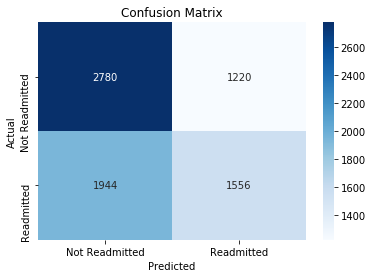

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train the model (fit the model on the training data)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_imputed, y_train)  # Make sure X_train_imputed and y_train are ready

# Step 2: Generate predictions on the test set
y_pred = clf.predict(X_test_imputed)  # Make sure X_test_imputed is the test set

# Step 3: Evaluate the model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Readmitted', 'Readmitted'], yticklabels=['Not Readmitted', 'Readmitted'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
